In [49]:
import pandas as pd
import numpy as np
import json
import folium
import fiona
import geopandas
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import seaborn as sns
from folium import plugins
import warnings
warnings.filterwarnings("ignore")
sns.set(style='whitegrid')
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(13.7,10.27)})

In [2]:
meses   = ('Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
          'Julio', 'Agosto', 'Septiembre', 'Octubre','Nobiembre', 'Diciembre')

In [2]:
df = pd.read_csv('siniestralidad_sin_actor_vial.csv', index_col=0)

In [3]:
%%time

siniestralidad_geo = geopandas.read_file('.\Data\Siniestros viales\Historico.geojson') 

#fuente: https://datosabiertos.bogota.gov.co/dataset/0b070626-fe5a-42dc-ae99-92601da166d9/resource

siniestralidad_1 = pd.read_excel(r'.\Data\Siniestros viales\2015_2019_siniestralidad_vial.xlsx','SINIESTROS') 

siniestralidad_actor_vial = pd.read_excel(r'.\Data\Siniestros viales\2015_2019_siniestralidad_vial.xlsx','ACTOR_VIAL') 

siniestralidad_vehiculos = pd.read_excel(r'.\Data\Siniestros viales\2015_2019_siniestralidad_vial.xlsx','VEHICULOS') 

siniestralidad_hipotesis = pd.read_excel(r'.\Data\Siniestros viales\2015_2019_siniestralidad_vial.xlsx','HIPOTESIS')

print('Archivos cargados')

Archivos cargados
Wall time: 8min 50s


**Comment:** Creating columns "lon" and "lat" (longitud and latitud)

In [4]:
siniestralidad_geo['lon'] = siniestralidad_geo.geometry.apply(lambda p: p.x)
siniestralidad_geo['lat'] = siniestralidad_geo.geometry.apply(lambda p: p.y)

**Comment:** Checking dataframes

In [96]:
siniestralidad_1.head(5)

CODIGO_SINIESTRO       FECHA      HORA     GRAVEDAD        CLASE  \
0           4401423  01/01/2015  09:45:00  Con Heridos       Choque   
1           4401425  01/01/2015  13:25:00   Solo Daños       Choque   
2           4401430  01/01/2015  07:15:00  Con Heridos  Volcamiento   
3           4401433  01/01/2015  20:30:00   Solo Daños       Choque   
4           4401437  01/01/2015  12:50:00   Solo Daños       Choque   

  CHOQUE_CON OBJETO_FIJO          DIRECCION  TOTAL_MUERTOS  TOTAL_HERIDOS  \
0   Vehiculo         NaN    CL 66A-KR 76 02              0              2   
1   Vehiculo         NaN  CL 143A-KR 142 02              0              0   
2        NaN         NaN  KR 19D-CL 62 S 02              0              1   
3   Vehiculo         NaN      AK 7-CL 43 33              0              0   
4   Vehiculo         NaN   DG 77A-AK 18D 02              0              0   

        LOCALIDAD  DISENO_LUGAR  
0        Engativá  Interseccion  
1            Suba  Tramo de Via  
2  Ciudad Bolívar  Tramo de Via  
3       Chapinero  Tramo de Via  
4  Ciudad Bolívar  Tramo de Via

In [97]:
siniestralidad_actor_vial.head()

CODIGO_SINIESTRO       FECHA  CONDICION  ESTADO  EDAD       SEXO   VEHICULO
0           4401420  01/01/2015  CONDUCTOR   ILESO  20.0  MASCULINO  4401420-2
1           4401429  01/01/2015     PEATON  HERIDO  28.0  MASCULINO        NaN
2           4401442  01/01/2015   PASAJERO  HERIDO  22.0  MASCULINO  4401442-1
3           4401442  01/01/2015     PEATON  HERIDO  57.0  MASCULINO        NaN
4           4401423  01/01/2015     PEATON  HERIDO  19.0   FEMENINO        NaN

In [93]:
siniestralidad_vehiculos.head()

CODIGO_SINIESTRO       FECHA   VEHICULO        CLASE    SERVICIO ENFUGA
0           4401429  01/01/2015  4401429-1     Microbus     Publico      N
1           4401449  01/01/2015  4401449-1  Motocicleta  Particular      N
2           4401453  01/01/2015  4401453-1          Bus     Publico      N
3           4401453  01/01/2015  4401453-2    Automovil     Publico      N
4           4401447  01/01/2015  4401447-1    Automovil     Publico      N

In [94]:
siniestralidad_hipotesis.head()

CODIGO_SINIESTRO       FECHA CODIGO_CAUSA  \
0           4401449  01/01/2015          114   
1           4401447  01/01/2015          121   
2           4401438  01/01/2015          157   
3           4401429  01/01/2015          116   
4           4401433  01/01/2015          121   

                          DESCRIPCION  CODIGO_CAUSA2 DESCRIPCION2  
0                 EMBRIAGUEZ APARENTE            NaN          NaN  
1  NO MANTENER DISTANCIA DE SEGURIDAD            NaN          NaN  
2                                OTRA            NaN          NaN  
3                 EXCESO DE VELOCIDAD            NaN          NaN  
4  NO MANTENER DISTANCIA DE SEGURIDAD            NaN          NaN

**Comment:** Adjusting the dataframe siniestralidad_vehiculos

In [5]:
z=pd.DataFrame(siniestralidad_vehiculos.groupby(
    ('CODIGO_SINIESTRO','CLASE'))['CLASE'].count().reset_index(name='CLASE_COUNT'))
x=pd.DataFrame(siniestralidad_vehiculos.groupby(
    ('CODIGO_SINIESTRO','SERVICIO'))['SERVICIO'].count().reset_index(name='SERVICIO_COUNT'))

z=z.pivot_table(
    index='CODIGO_SINIESTRO', columns='CLASE', values='CLASE_COUNT', fill_value = 0).reset_index()
x=x.pivot_table(
    index='CODIGO_SINIESTRO', columns='SERVICIO', values='SERVICIO_COUNT', fill_value = 0).reset_index()

siniestralidad_vehiculos_fx = pd.merge(x, z, how='inner', left_on='CODIGO_SINIESTRO', right_on='CODIGO_SINIESTRO')

In [6]:
siniestralidad_geo_1 = pd.merge(
    siniestralidad_geo, 
    siniestralidad_1[['CODIGO_SINIESTRO', 
                      'OBJETO_FIJO',                                           
                      'TOTAL_MUERTOS', 
                      'TOTAL_HERIDOS',
                      'DISENO_LUGAR',
                      'HORA']], 
                       how = 'inner', 
                       left_on = 'CODIGO_ACCIDENTE', 
                       right_on = 'CODIGO_SINIESTRO')

In [7]:
siniestralidad_geo_1_hipotesis = pd.merge(
    siniestralidad_geo_1,
    siniestralidad_hipotesis[['CODIGO_SINIESTRO',
                              'CODIGO_CAUSA',
                              'DESCRIPCION',
                              'CODIGO_CAUSA2',
                              'DESCRIPCION2']],
                              how = 'inner',
                              left_on = 'CODIGO_ACCIDENTE', 
                              right_on = 'CODIGO_SINIESTRO')

In [8]:
siniestralidad_geo_1_hipotesis_vehiculo = pd.merge(
    siniestralidad_geo_1_hipotesis,
    siniestralidad_vehiculos_fx,
                              how = 'inner',
                              left_on = 'CODIGO_ACCIDENTE', 
                              right_on = 'CODIGO_SINIESTRO')

In [9]:
del siniestralidad_geo_1_hipotesis_vehiculo['CODIGO_SINIESTRO_y']
del siniestralidad_geo_1_hipotesis_vehiculo['CODIGO_SINIESTRO_x']
del siniestralidad_geo_1_hipotesis_vehiculo['CODIGO_SINIESTRO']

In [10]:
siniestralidad_geo_1_hipotesis_vehiculo.head()

OBJECTID  FORMULARIO  CODIGO_ACCIDENTE  ANO_OCURRENCIA_ACC  \
0         1  A000640275           4484660                2017   
1         7  A000200705           4412699                2015   
2         8  A000402862           4447845                2016   
3        10  A000240105           4424883                2015   
4        12  A000695058           4503701                2017   

                    DIRECCION    GRAVEDAD CLASE_ACC   LOCALIDAD_GEO  \
0  AV AVENIDA BOYACA-CL 79 02  SOLO DANOS    CHOQUE        ENGATIVA   
1           CL 63A-KR 72 S 02  SOLO DANOS    CHOQUE  CIUDAD BOLIVAR   
2               KR 27-CL 9 14  SOLO DANOS    CHOQUE    LOS MARTIRES   
3           KR 52A-CL 137A 35  SOLO DANOS    CHOQUE            SUBA   
4             KR 45-CL 150 02  SOLO DANOS    CHOQUE            SUBA   

        LOCALIDAD       FECHA_HORA_ACC  ...  Camion, Furgon  Camioneta  \
0        ENGATIVA  2017-06-12T05:30:00  ...               0          1   
1  CIUDAD BOLIVAR  2015-05-11T10:50:00  ...               1          0   
2    LOS MARTIRES  2016-06-08T21:30:00  ...               0          1   
3            SUBA  2015-09-26T18:00:00  ...               0          0   
4         USAQUEN  2017-12-21T13:10:00  ...               0          0   

  Campero  Cuatrimoto  Microbus Motocarro  Motocicleta  Motociclo  \
0       0           0         0         0            0          0   
1       0           0         0         0            0          0   
2       0           0         0         0            0          0   
3       0           0         0         0            0          0   
4       0           0         0         0            0          0   

  Tractocamion Volqueta  
0            0        0  
1            0        0  
2            0        0  
3            0        0  
4            0        0  

[5 rows x 42 columns]

In [11]:
siniestralidad_geo_1_hipotesis_vehiculo['TOTAL_VICTIMAS'] = (
    siniestralidad_geo_1_hipotesis_vehiculo['TOTAL_MUERTOS'] + 
siniestralidad_geo_1_hipotesis_vehiculo['TOTAL_HERIDOS'])


df = siniestralidad_geo_1_hipotesis_vehiculo.copy()


df['HOUR'] = pd.to_datetime(df['FECHA_HORA_ACC']).dt.hour

df['DAY']=pd.to_datetime(df['FECHA_HORA_ACC']).dt.weekday

df['MONTH']=pd.to_datetime(df['FECHA_HORA_ACC']).dt.month

df['CODIGO_CAUSA'] = df['CODIGO_CAUSA'].astype(str)
df['CODIGO_CAUSA'] = df['CODIGO_CAUSA'].str.replace('ANT-','99').astype(float)

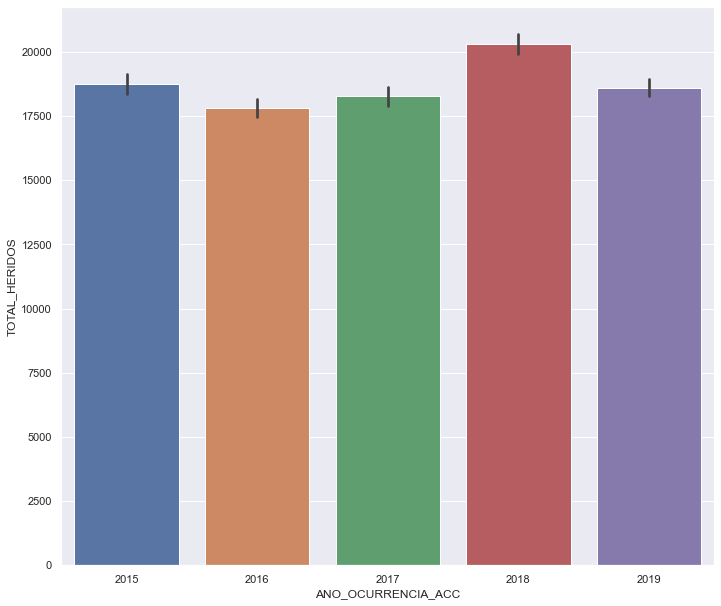

In [107]:
sns.barplot(x="ANO_OCURRENCIA_ACC", y="TOTAL_HERIDOS", data=df, estimator=sum);

<AxesSubplot:xlabel='ANO_OCURRENCIA_ACC', ylabel='TOTAL_MUERTOS'>

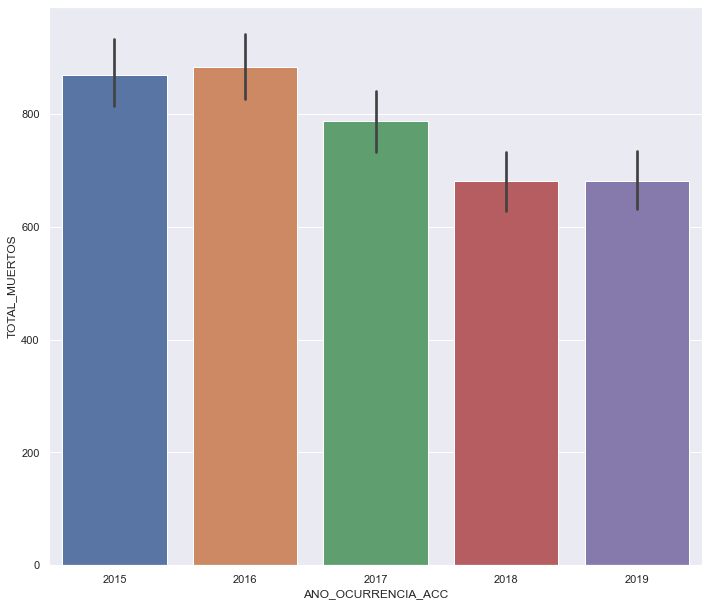

In [44]:
sns.set(rc={'figure.figsize':(11.7,10.27)})
sns.barplot(x="ANO_OCURRENCIA_ACC", y="TOTAL_MUERTOS", data=df, estimator=sum)

<AxesSubplot:title={'center':'Gravedad del siniestro'}>

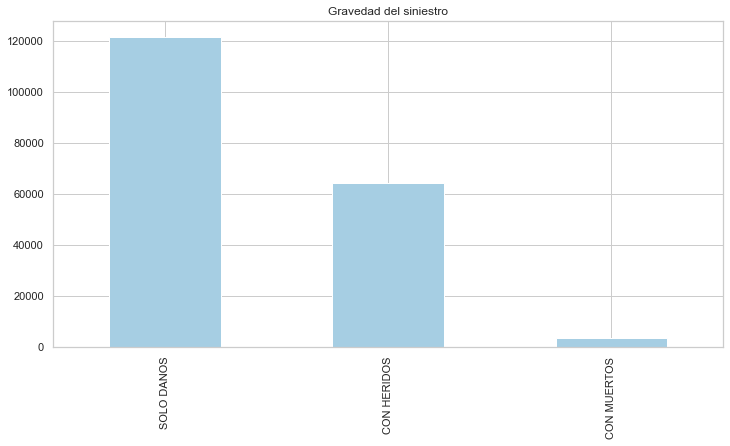

In [111]:
df['GRAVEDAD'].value_counts().plot(kind='bar', figsize=(12,6), title='Gravedad del siniestro', colormap='Paired')

<AxesSubplot:title={'center':'Clase del siniestro'}>

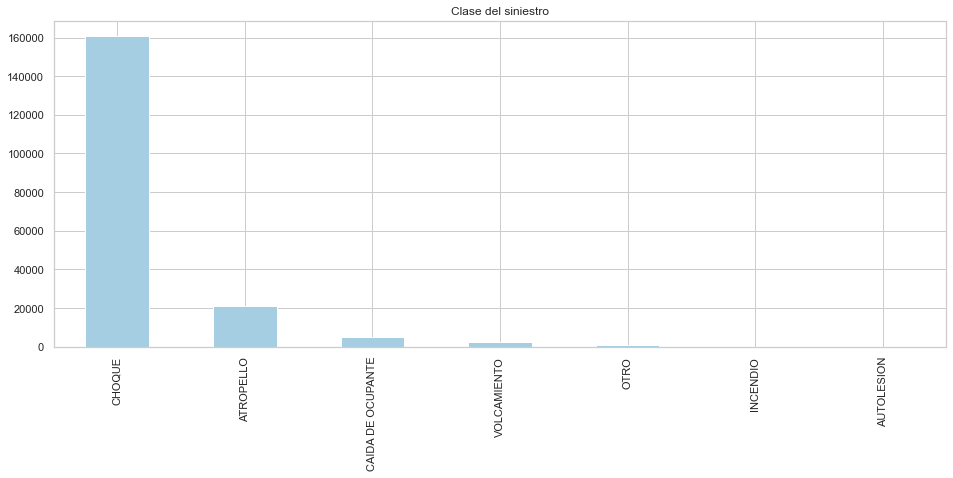

In [112]:
df['CLASE_ACC'].value_counts().plot(kind='bar', figsize=(16,6), title='Clase del siniestro', colormap='Paired')

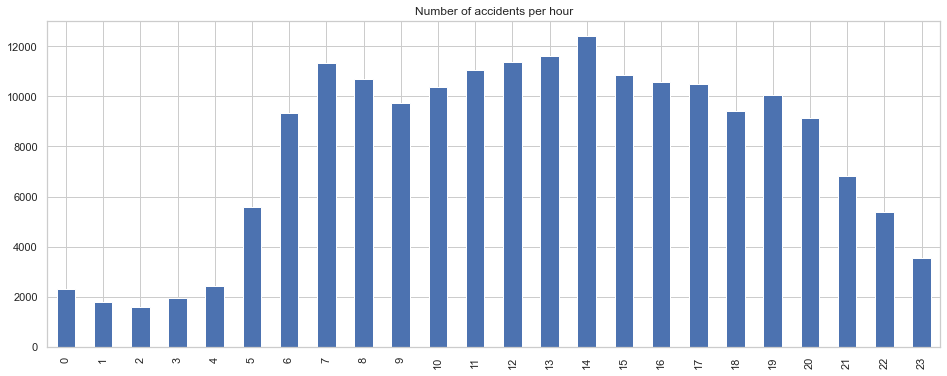

In [113]:
df['HOUR'].value_counts().sort_index().plot(
    kind="bar",title='Number of accidents per hour',figsize = (16, 6))
plt.savefig('accidents_per_hour.png')

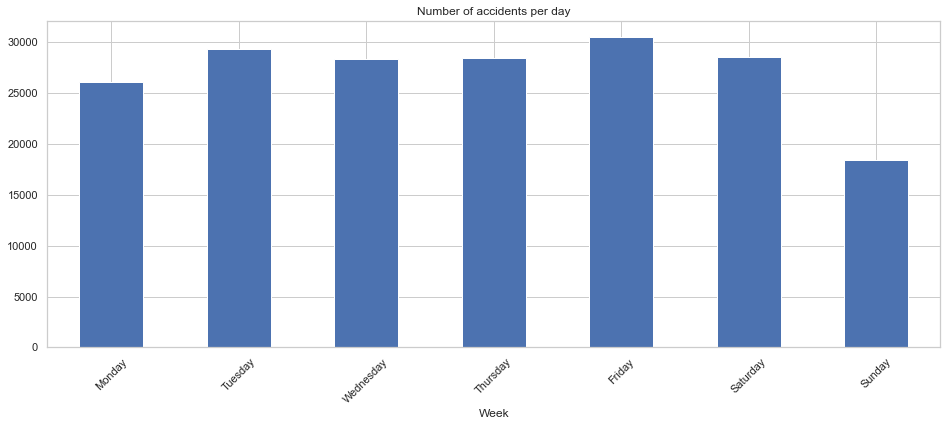

In [114]:
week   = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
b=df['DAY'].value_counts().sort_index()
b.index=week
plt.xlabel('Week')
b.plot(kind="bar",title='Number of accidents per day',figsize = (16, 6))
plt.xticks(rotation=45);

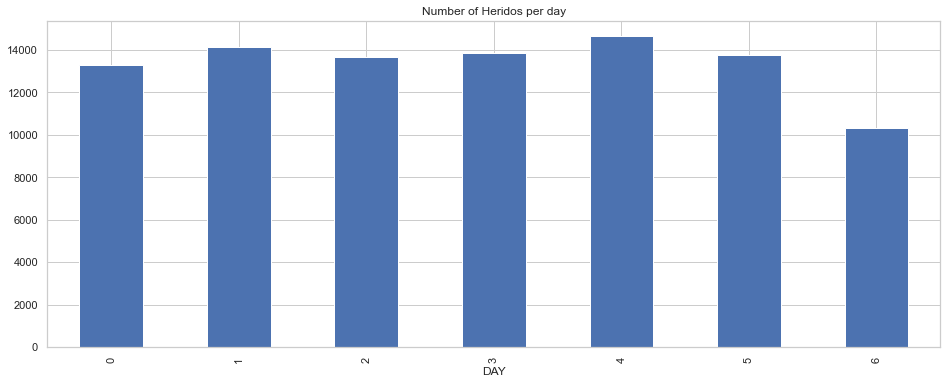

In [115]:
df.groupby('DAY')['TOTAL_HERIDOS'].sum().plot(
    kind="bar",title='Number of Heridos per day',figsize = (16, 6));

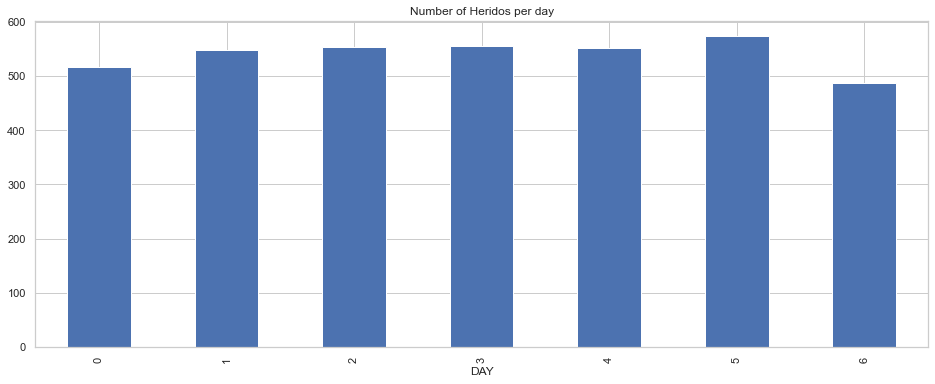

In [116]:
plt.xlabel('week')
df.groupby('DAY')['TOTAL_MUERTOS'].sum().plot(
    kind="bar",title='Number of deaths per day',figsize = (16, 6));

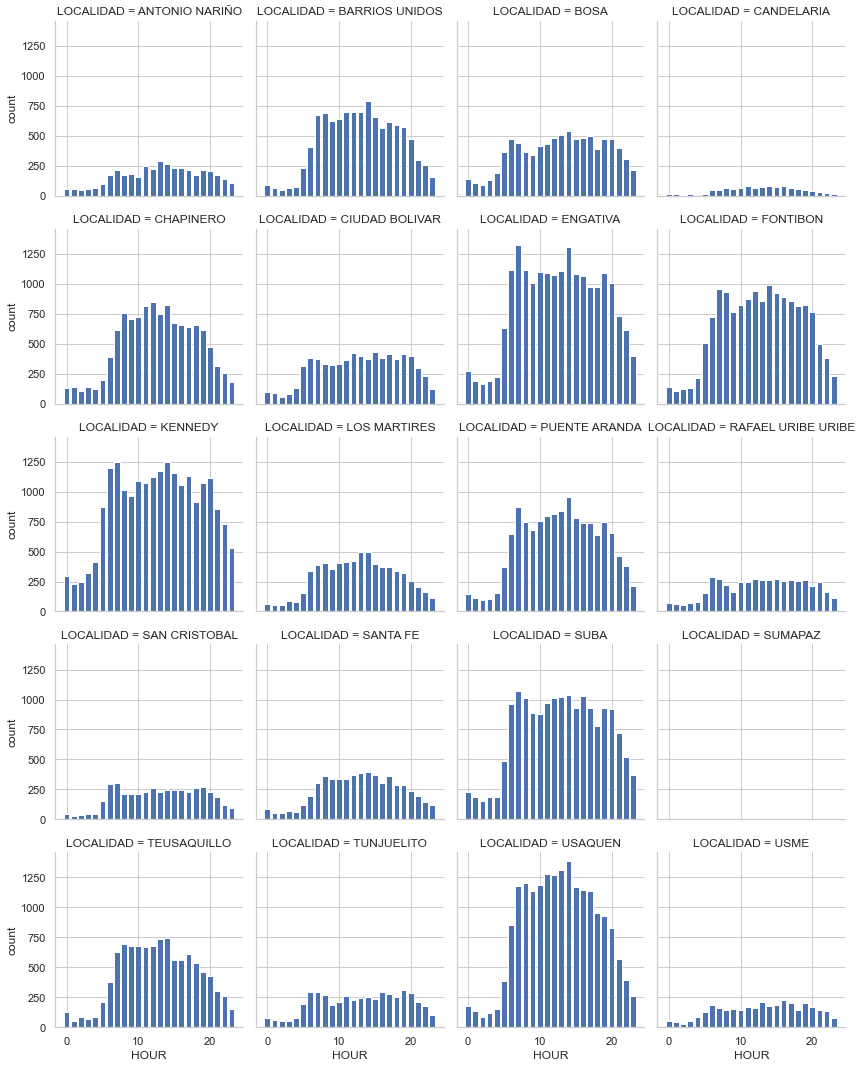

In [117]:
z=df.groupby('LOCALIDAD')['HOUR'].value_counts().reset_index(name='count')
g = sns.FacetGrid(z,col='LOCALIDAD', col_wrap=4)
g.map(plt.bar,"HOUR","count");

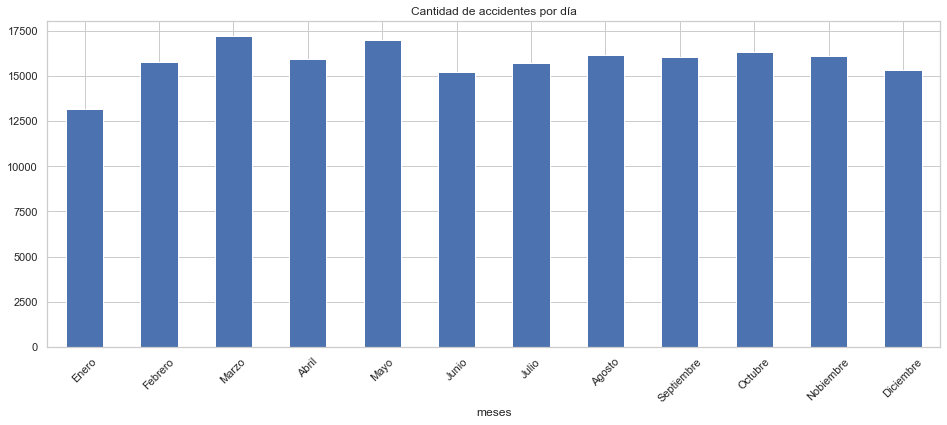

In [118]:
b=df['MONTH'].value_counts().sort_index()
b.index=meses
plt.xlabel('meses')
b.plot(kind="bar",title='Cantidad de accidentes por día',figsize = (16, 6))
plt.xticks(rotation=45);

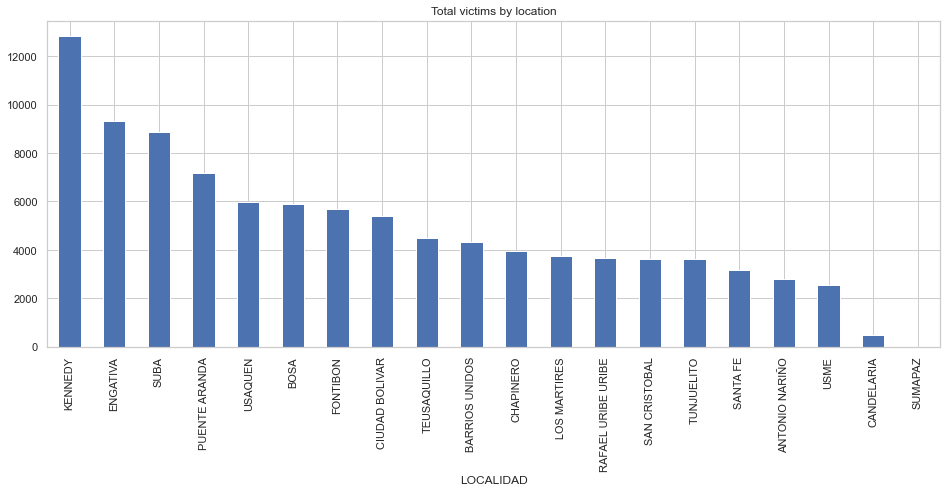

In [119]:
df.groupby('LOCALIDAD')['TOTAL_VICTIMAS'].sum().sort_values(
    ascending=False).plot(kind='bar', figsize=(16,6), title='Total victims by location');

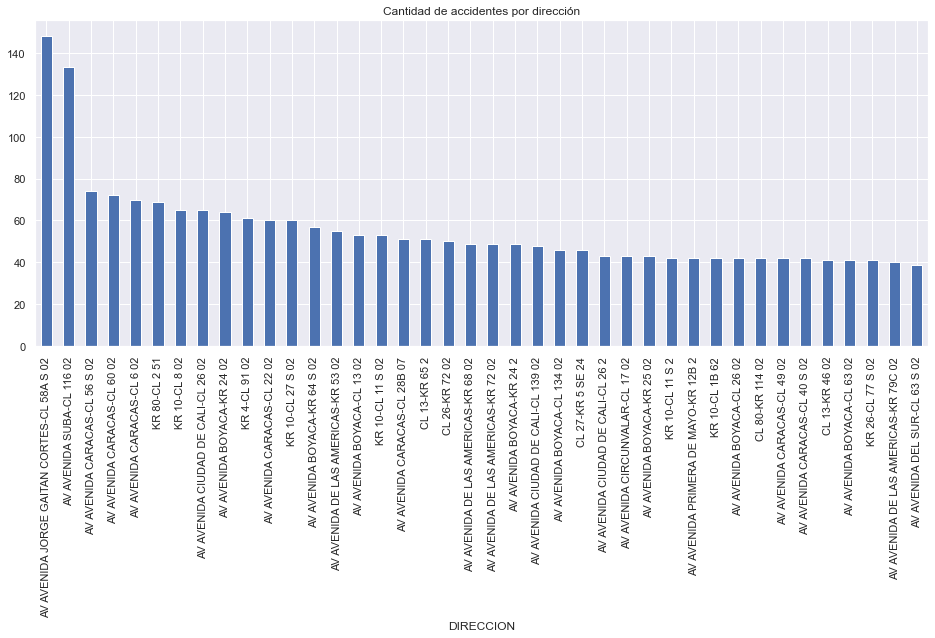

In [84]:
df.groupby('DIRECCION')['TOTAL_VICTIMAS'].sum().sort_values(ascending=False).head(40).plot(
    kind="bar",title='Cantidad de accidentes por dirección',figsize = (16, 6));

In [121]:
df.groupby('DIRECCION')['TOTAL_VICTIMAS'].sum().sort_values(ascending=False).head(5)

DIRECCION
AV AVENIDA JORGE GAITAN CORTES-CL 58A S 02    148
AV AVENIDA SUBA-CL 116 02                     133
AV AVENIDA CARACAS-CL 56 S 02                  74
AV AVENIDA CARACAS-CL 60 02                    72
AV AVENIDA CARACAS-CL 6 02                     70
Name: TOTAL_VICTIMAS, dtype: int64

<AxesSubplot:xlabel='DESCRIPCION', ylabel='TOTAL_VICTIMAS'>

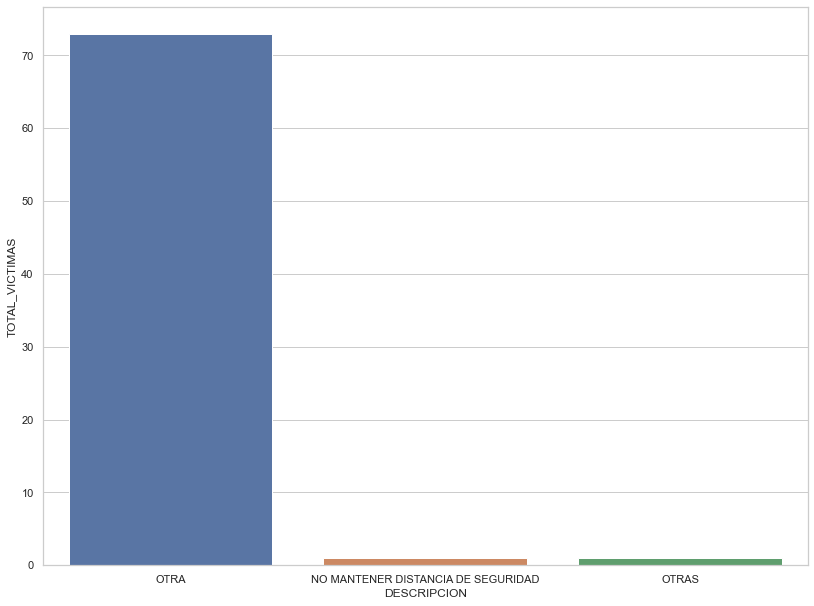

In [189]:
gp = df[df['DIRECCION']=='AV AVENIDA JORGE GAITAN CORTES-CL 58A S 02'].groupby('DESCRIPCION')['TOTAL_VICTIMAS'].sum()
gp = pd.DataFrame(gp)
gp = gp.sort_values(by='TOTAL_VICTIMAS', ascending=False).head(3)
sns.barplot(x=gp.index, y='TOTAL_VICTIMAS', data=gp)

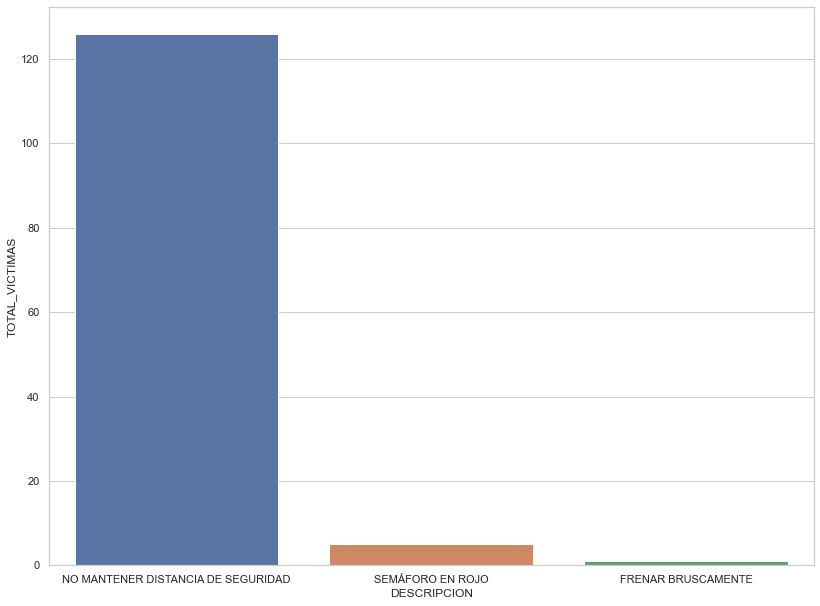

In [190]:
gp = df[df['DIRECCION']=='AV AVENIDA SUBA-CL 116 02'].groupby('DESCRIPCION')['TOTAL_VICTIMAS'].sum()
gp = pd.DataFrame(gp)
gp = gp.sort_values(by='TOTAL_VICTIMAS', ascending=False).head(3)
sns.barplot(x=gp.index, y='TOTAL_VICTIMAS', data=gp);

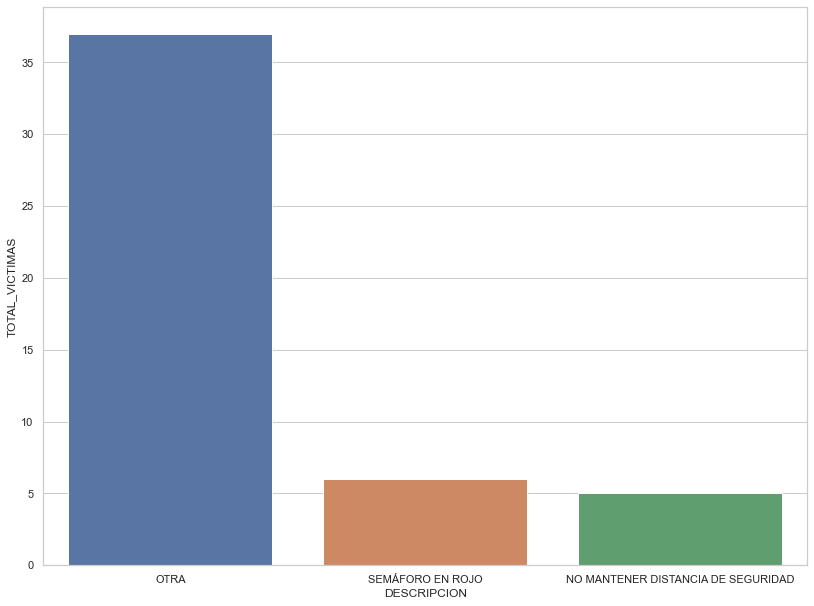

In [191]:
gp = df[df['DIRECCION']=='AV AVENIDA CARACAS-CL 56 S 02'].groupby('DESCRIPCION')['TOTAL_VICTIMAS'].sum()
gp = pd.DataFrame(gp)
gp = gp.sort_values(by='TOTAL_VICTIMAS', ascending=False).head(3)
sns.barplot(x=gp.index, y='TOTAL_VICTIMAS', data=gp);

<AxesSubplot:ylabel='TOTAL_MUERTOS'>

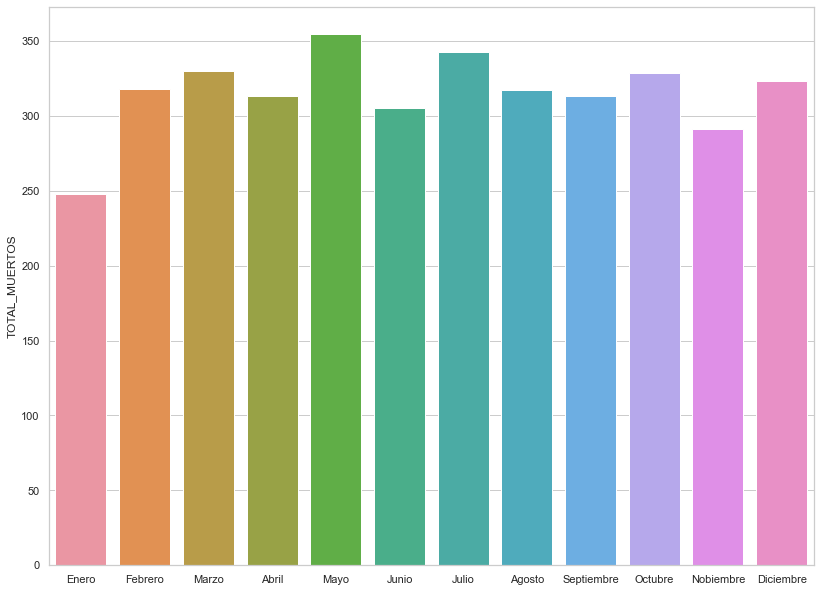

In [125]:
gp = df.groupby('MONTH')['TOTAL_MUERTOS'].sum()
gp.index=meses
gp = pd.DataFrame(gp)
sns.barplot(x=gp.index, y='TOTAL_MUERTOS',data=gp)

<AxesSubplot:ylabel='TOTAL_HERIDOS'>

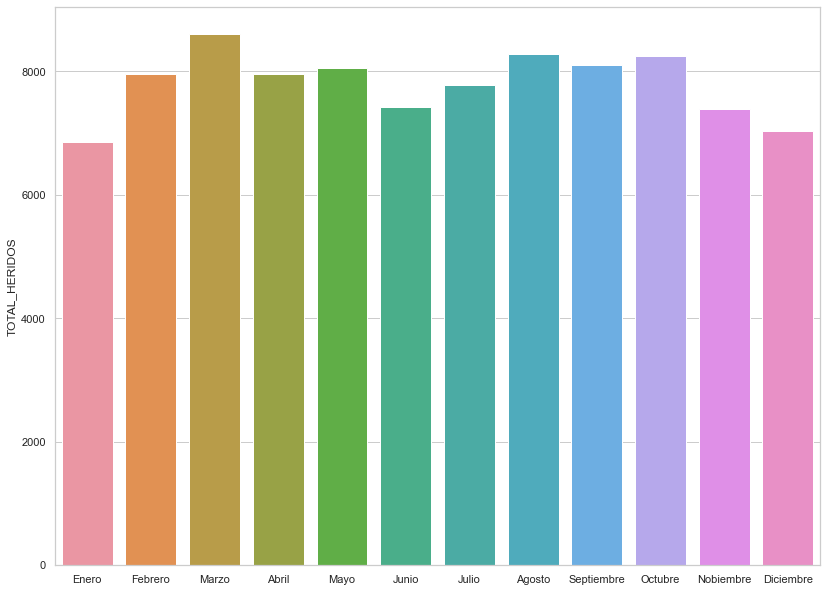

In [126]:
gp = df.groupby('MONTH')['TOTAL_HERIDOS'].sum()
gp.index=meses
gp = pd.DataFrame(gp)
sns.barplot(x=gp.index, y='TOTAL_HERIDOS',data=gp)

<AxesSubplot:xlabel='TOTAL_MUERTOS', ylabel='DESCRIPCION'>

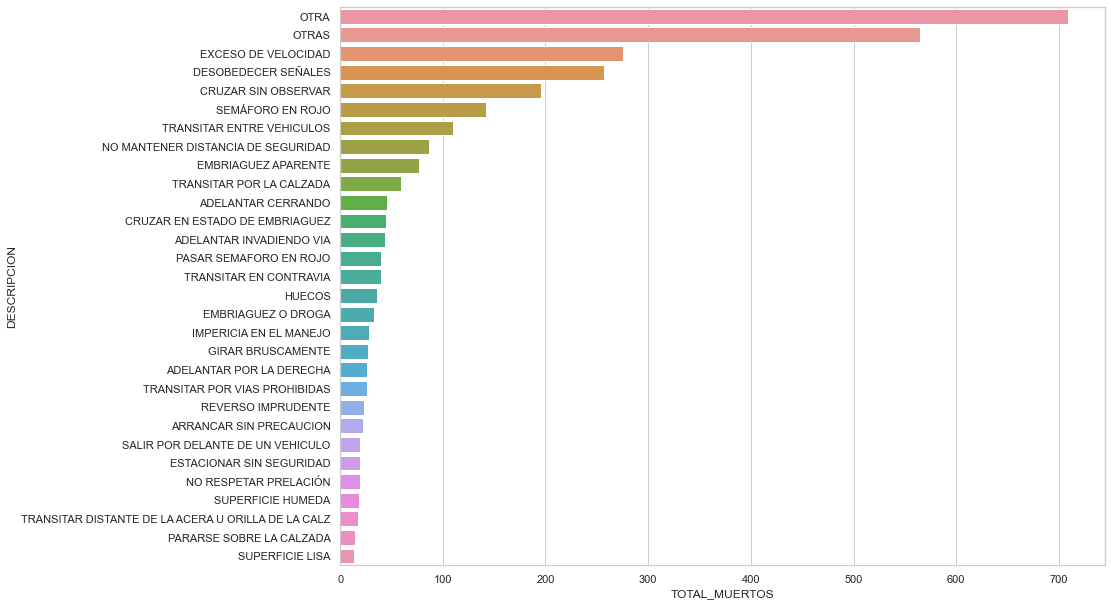

In [127]:
gp = df.groupby('DESCRIPCION')['TOTAL_MUERTOS'].sum()
gp = pd.DataFrame(gp)
gp = gp.sort_values(by='TOTAL_MUERTOS', ascending=False).head(30)
sns.barplot(y=gp.index, x='TOTAL_MUERTOS', data=gp)

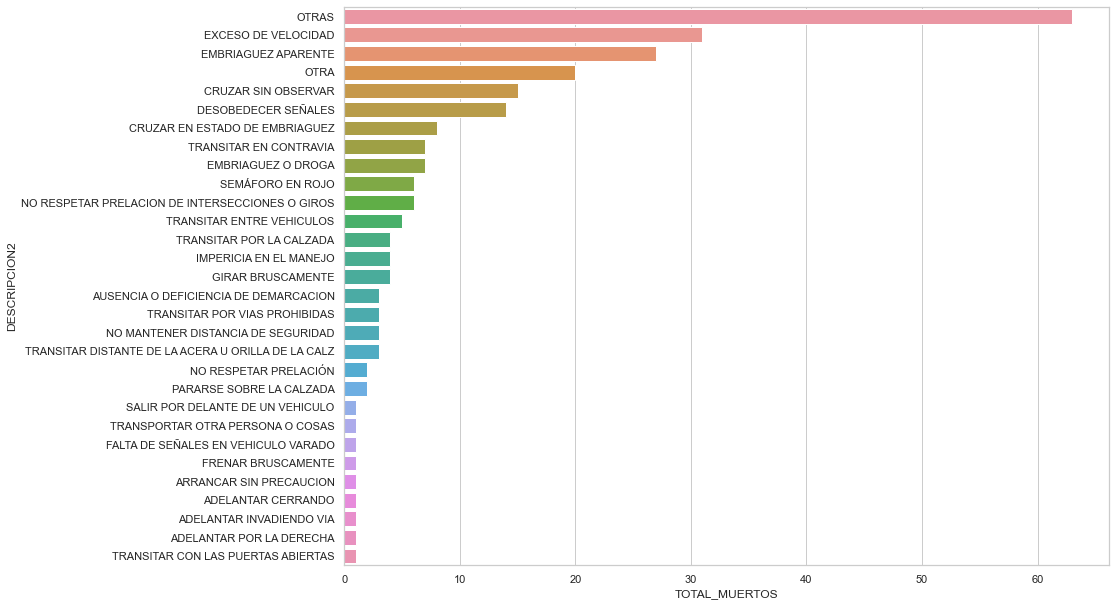

In [128]:
gp = df.groupby('DESCRIPCION2')['TOTAL_MUERTOS'].sum()
gp = pd.DataFrame(gp)
gp = gp.sort_values(by='TOTAL_MUERTOS', ascending=False).head(30)
sns.barplot(y=gp.index, x='TOTAL_MUERTOS', data=gp);

<AxesSubplot:xlabel='TOTAL_HERIDOS', ylabel='DESCRIPCION'>

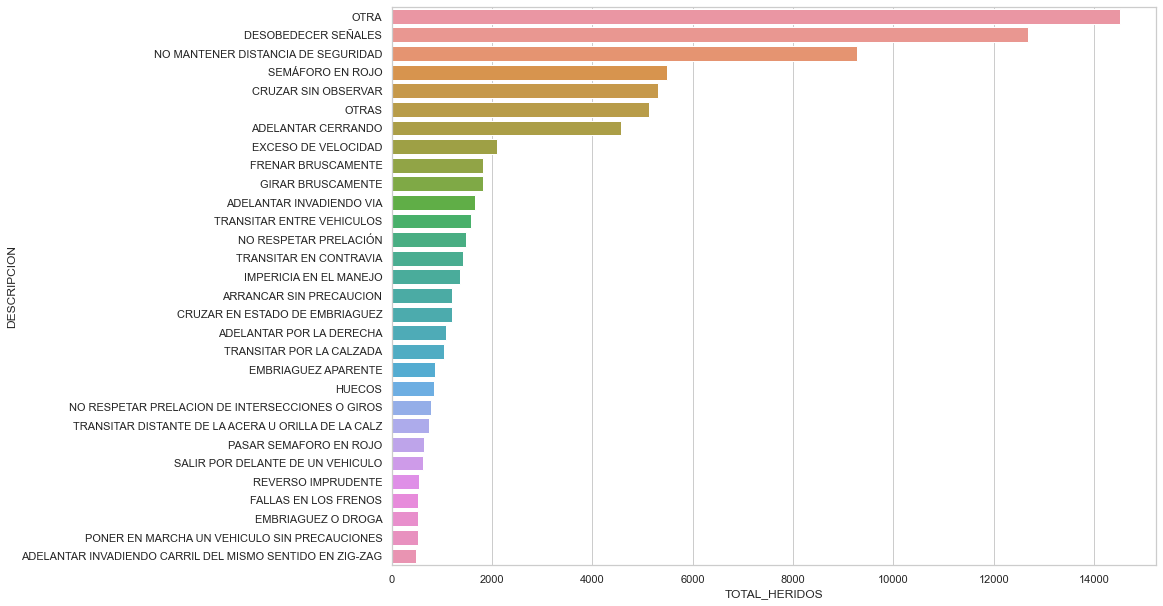

In [129]:
gp = df.groupby('DESCRIPCION')['TOTAL_HERIDOS'].sum()
gp = pd.DataFrame(gp)
gp = gp.sort_values(by='TOTAL_HERIDOS', ascending=False).head(30)
sns.barplot(y=gp.index, x='TOTAL_HERIDOS', data=gp)

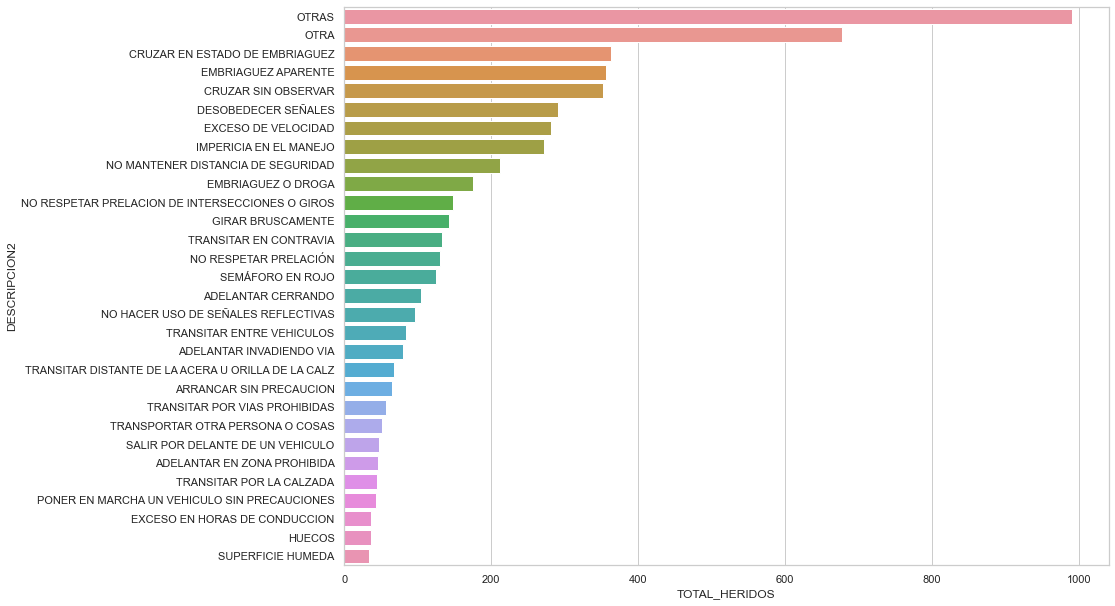

In [130]:
gp = df.groupby('DESCRIPCION2')['TOTAL_HERIDOS'].sum()
gp = pd.DataFrame(gp)
gp = gp.sort_values(by='TOTAL_HERIDOS', ascending=False).head(30)
sns.barplot(y=gp.index, x='TOTAL_HERIDOS', data=gp);

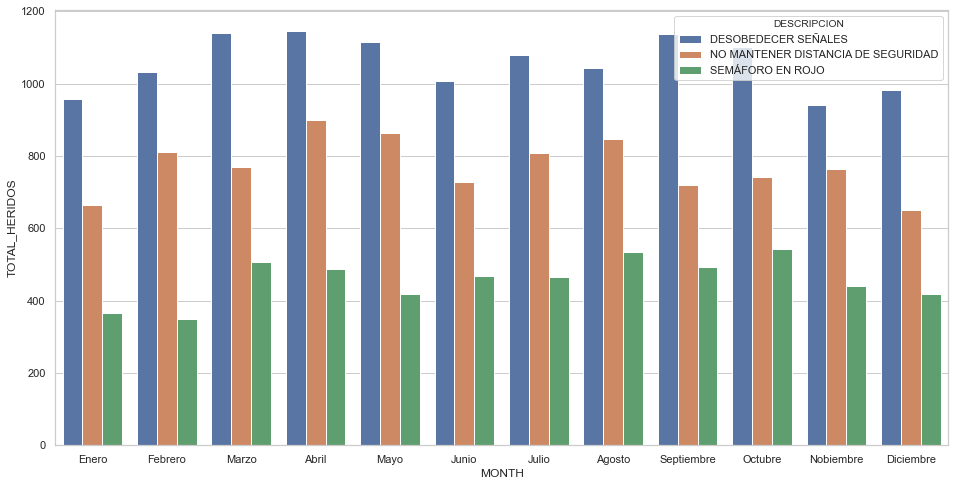

In [131]:
plt.figure(figsize=(16,8))
conditions=(
    (df['DESCRIPCION']=='DESOBEDECER SEÑALES') | 
    (df['DESCRIPCION']=='NO MANTENER DISTANCIA DE SEGURIDAD' ) |
    (df['DESCRIPCION']=='SEMÁFORO EN ROJO'))

gp = df[conditions].groupby((
    'MONTH','DESCRIPCION'))['TOTAL_HERIDOS'].sum().reset_index()
gp = pd.DataFrame(gp)
ax = sns.barplot(x='MONTH', y='TOTAL_HERIDOS', hue='DESCRIPCION', data=gp)
ax.set_xticklabels(meses);

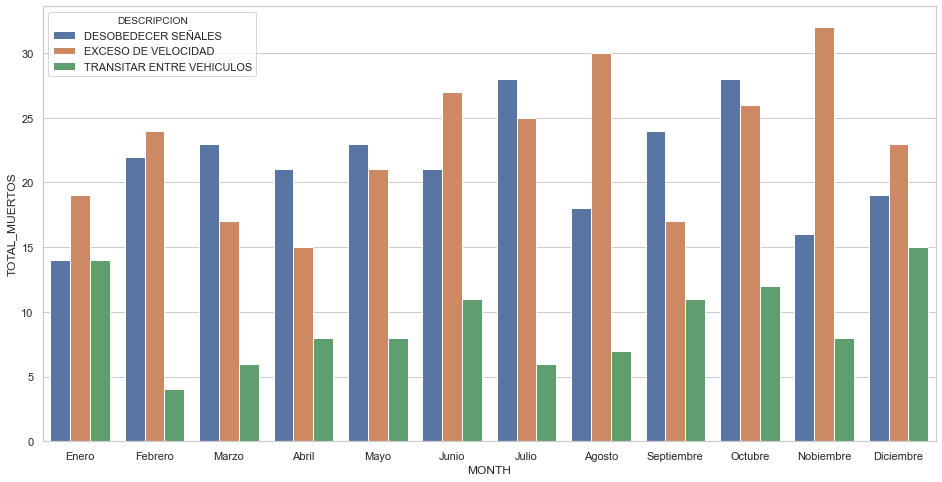

In [132]:
plt.figure(figsize=(16,8))
conditions=(
    (df['DESCRIPCION']=='DESOBEDECER SEÑALES') | 
    (df['DESCRIPCION']=='EXCESO DE VELOCIDAD' ) |
    (df['DESCRIPCION']=='TRANSITAR ENTRE VEHICULOS'))

gp = df[conditions].groupby((
    'MONTH','DESCRIPCION'))['TOTAL_MUERTOS'].sum().reset_index()
gp = pd.DataFrame(gp)
ax = sns.barplot(x='MONTH', y='TOTAL_MUERTOS', hue='DESCRIPCION', data=gp)
ax.set_xticklabels(meses);

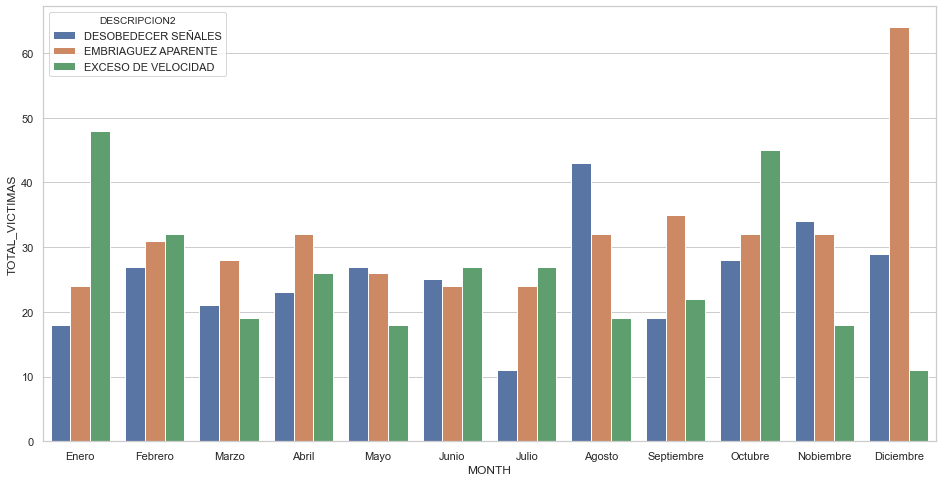

In [133]:
plt.figure(figsize=(16,8))
conditions=(
    (df['DESCRIPCION2']=='DESOBEDECER SEÑALES') | 
    (df['DESCRIPCION2']=='EXCESO DE VELOCIDAD' ) |
    (df['DESCRIPCION2']=='EMBRIAGUEZ APARENTE'))

gp = df[conditions].groupby((
    'MONTH','DESCRIPCION2'))['TOTAL_VICTIMAS'].sum().reset_index()
gp = pd.DataFrame(gp)
ax = sns.barplot(x='MONTH', y='TOTAL_VICTIMAS', hue='DESCRIPCION2', data=gp)
ax.set_xticklabels(meses);

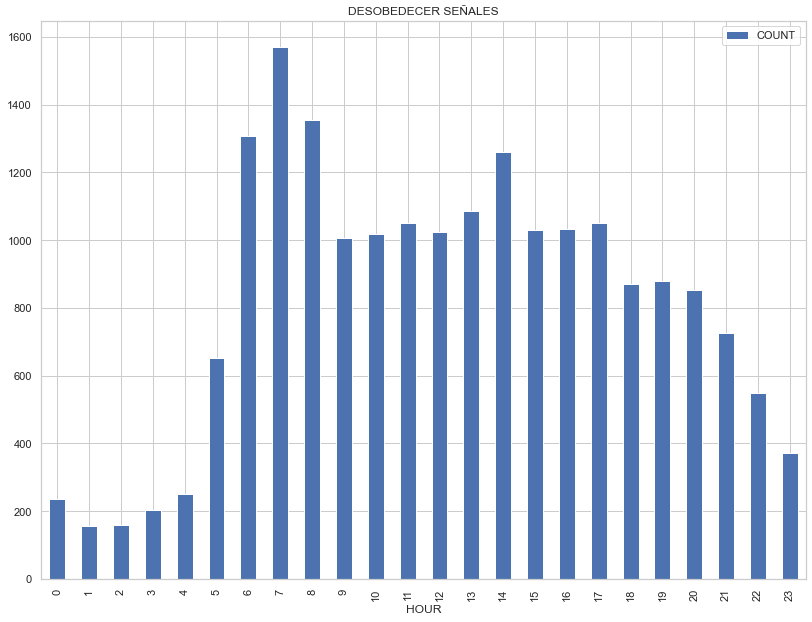

In [134]:
gp = df[df['DESCRIPCION']=='DESOBEDECER SEÑALES']['HOUR'].value_counts().reset_index().sort_values(by='index')
gp = gp.rename(columns={'index':'HOUR','HOUR':'COUNT'})
gp.plot(x='HOUR', kind='bar', title='DESOBEDECER SEÑALES');

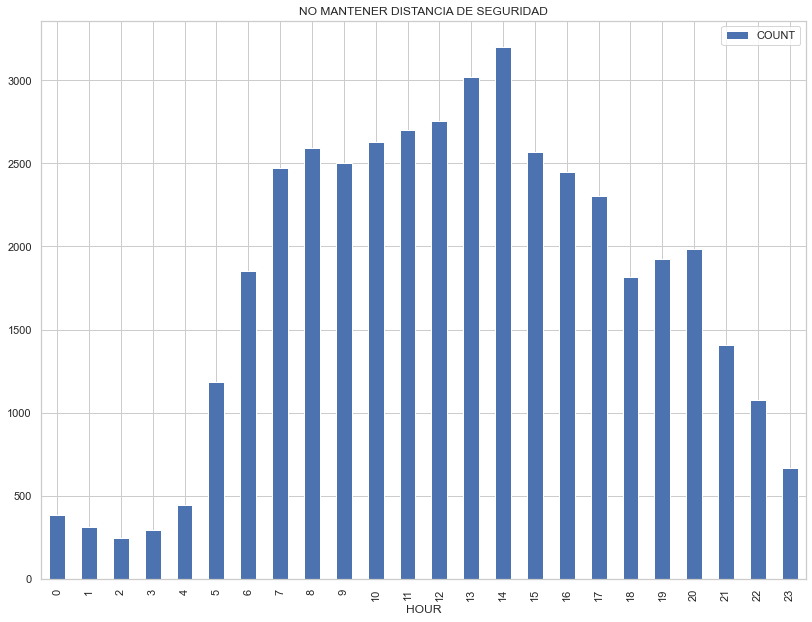

In [135]:
gp = df[df['DESCRIPCION']=='NO MANTENER DISTANCIA DE SEGURIDAD']['HOUR'].value_counts().reset_index().sort_values(by='index')
gp = gp.rename(columns={'index':'HOUR','HOUR':'COUNT'})
gp.plot(x='HOUR', kind='bar', title='NO MANTENER DISTANCIA DE SEGURIDAD');

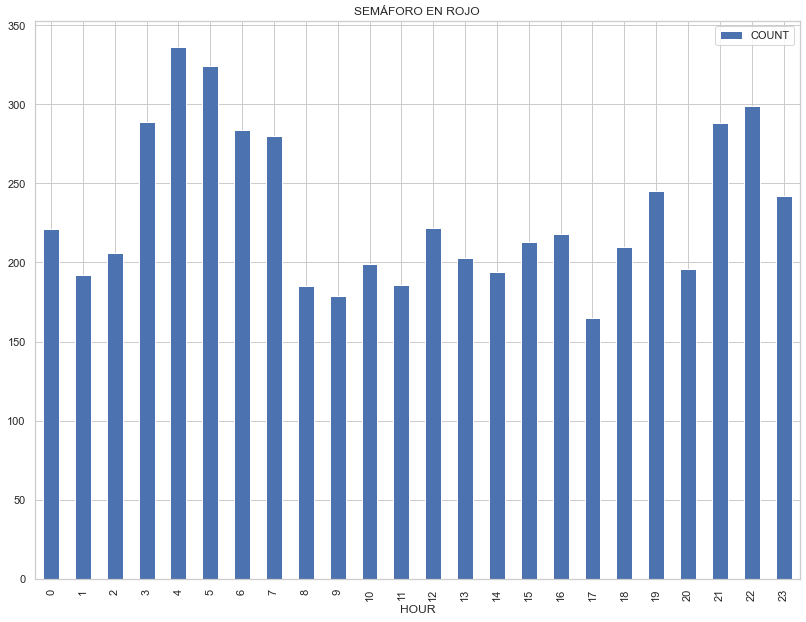

In [136]:
gp = df[df['DESCRIPCION']=='SEMÁFORO EN ROJO']['HOUR'].value_counts().reset_index().sort_values(by='index')
gp = gp.rename(columns={'index':'HOUR','HOUR':'COUNT'})
gp.plot(x='HOUR', kind='bar', title='SEMÁFORO EN ROJO');

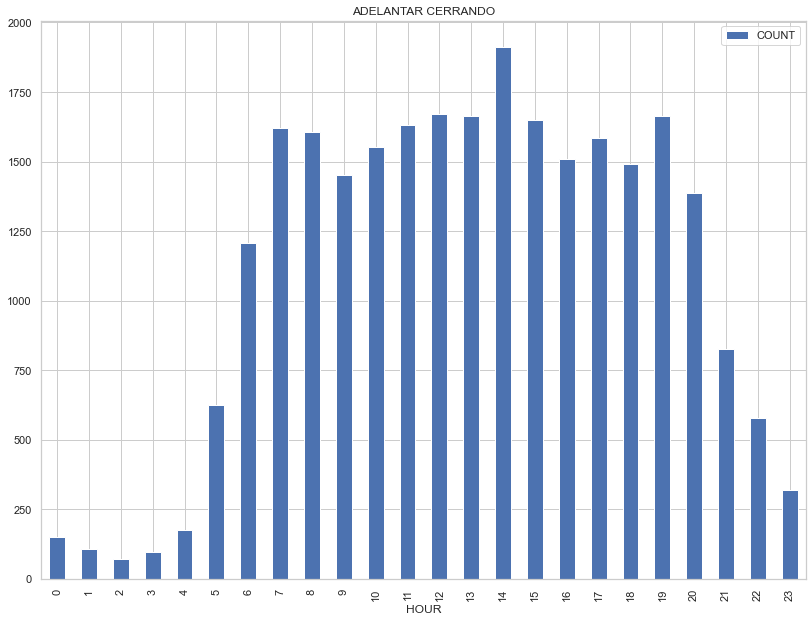

In [137]:
gp = df[df['DESCRIPCION']=='ADELANTAR CERRANDO']['HOUR'].value_counts().reset_index().sort_values(by='index')
gp = gp.rename(columns={'index':'HOUR','HOUR':'COUNT'})
gp.plot(x='HOUR', kind='bar', title='ADELANTAR CERRANDO');

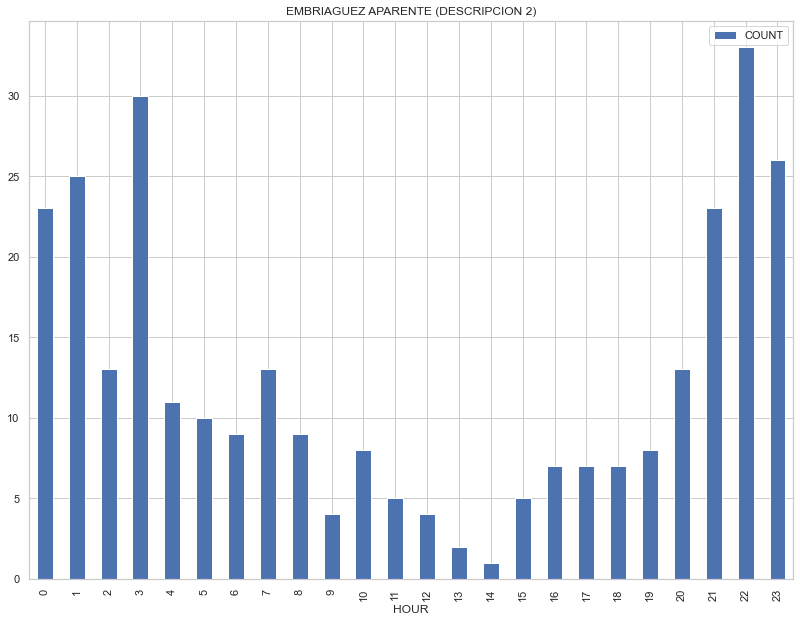

In [138]:
gp = df[df['DESCRIPCION2']=='EMBRIAGUEZ APARENTE']['HOUR'].value_counts().reset_index().sort_values(by='index')
gp = gp.rename(columns={'index':'HOUR','HOUR':'COUNT'})
gp.plot(x='HOUR', kind='bar', title='EMBRIAGUEZ APARENTE (DESCRIPCION 2)');

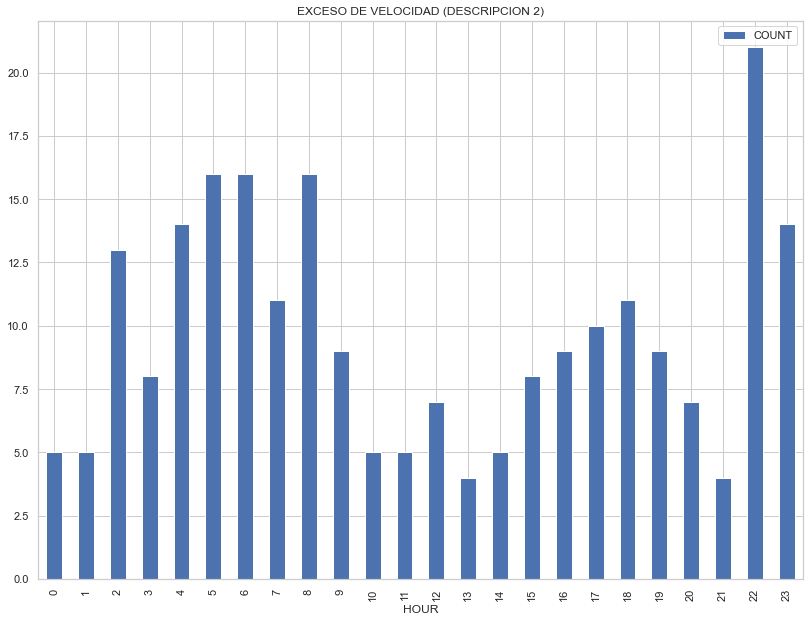

In [139]:
gp = df[df['DESCRIPCION2']=='EXCESO DE VELOCIDAD']['HOUR'].value_counts().reset_index().sort_values(by='index')
gp = gp.rename(columns={'index':'HOUR','HOUR':'COUNT'})
gp.plot(x='HOUR', kind='bar', title='EXCESO DE VELOCIDAD (DESCRIPCION 2)');

In [140]:
df3 = pd.read_excel(r'.\Data\Siniestros viales\comparendos_dei_por-infraccion_2011-a-2019.xlsx')

In [141]:
df3= df3.rename(columns={'AÑO_2011':2011,
                       'AÑO_2012':2012,
                       'AÑO_2013':2013,
                       'AÑO_2014':2014,
                       'AÑO_2015':2015,
                       'AÑO_2016':2016,
                       'AÑO_2017':2017,
                       'ANO_2018':2018,
                       'ANO_2019':2019})
df3.set_index('CÓDIGO_INFRACCIÓN', inplace=True)

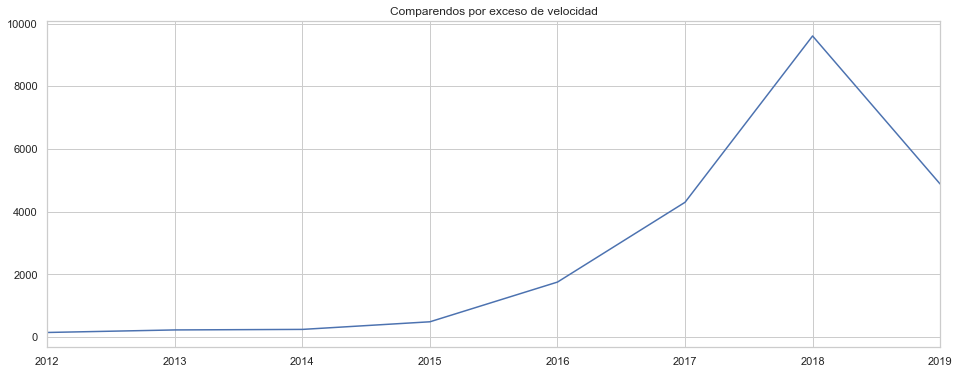

In [142]:
df3[df3['DESCRIPCIÓN_INFRACCIÓN'].str.contains('velocidad')].iloc[:, 2:11].sum(
).plot(figsize=(16,6), title='Comparendos por exceso de velocidad');

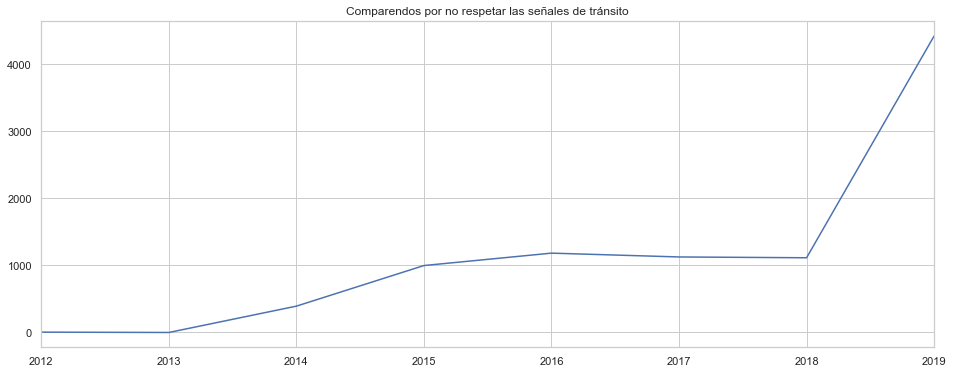

In [143]:
df3[df3.index=='A05'].iloc[:, 2:11].sum(
).plot(figsize=(16,6), title='Comparendos por no respetar las señales de tránsito');

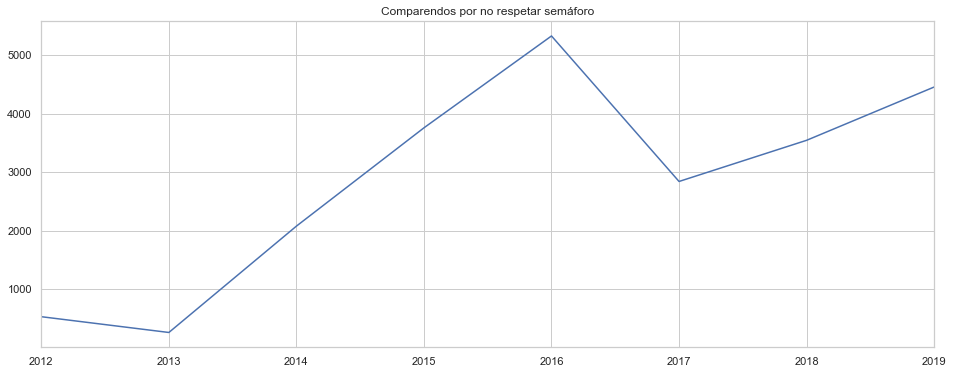

In [144]:
df3[df3.index=='D04'].iloc[:, 2:11].sum(
).plot(figsize=(16,6), title='Comparendos por no respetar semáforo');

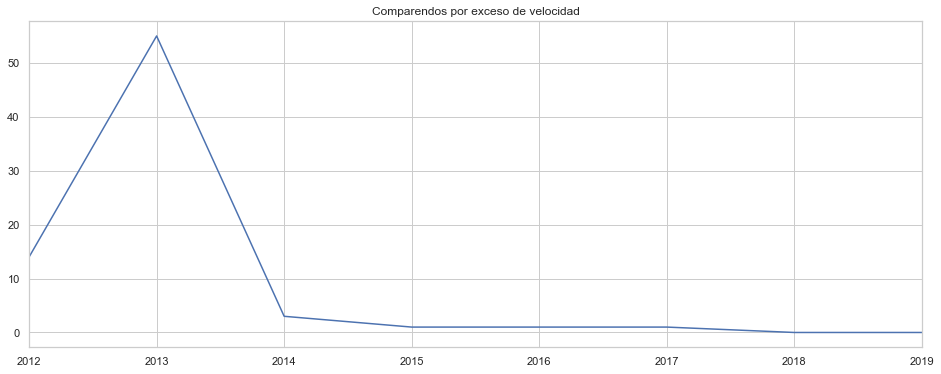

In [145]:
df3[df3['DESCRIPCIÓN_INFRACCIÓN'].str.contains('embriaguez')].iloc[:, 2:11].sum(
).plot(figsize=(16,6), title='Comparendos por exceso de velocidad');

In [146]:
siniestralidad_actor_vial = pd.read_excel(r'.\Data\Siniestros viales\2015_2019_siniestralidad_vial.xlsx','ACTOR_VIAL') 
df2 =siniestralidad_actor_vial.copy()

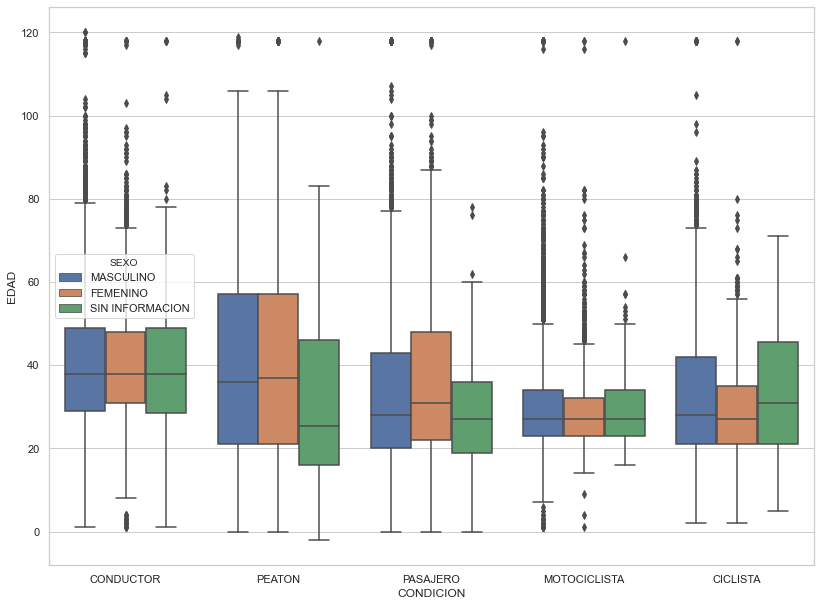

In [147]:
sns.boxplot(x="CONDICION", hue="SEXO", y="EDAD", data=df2);

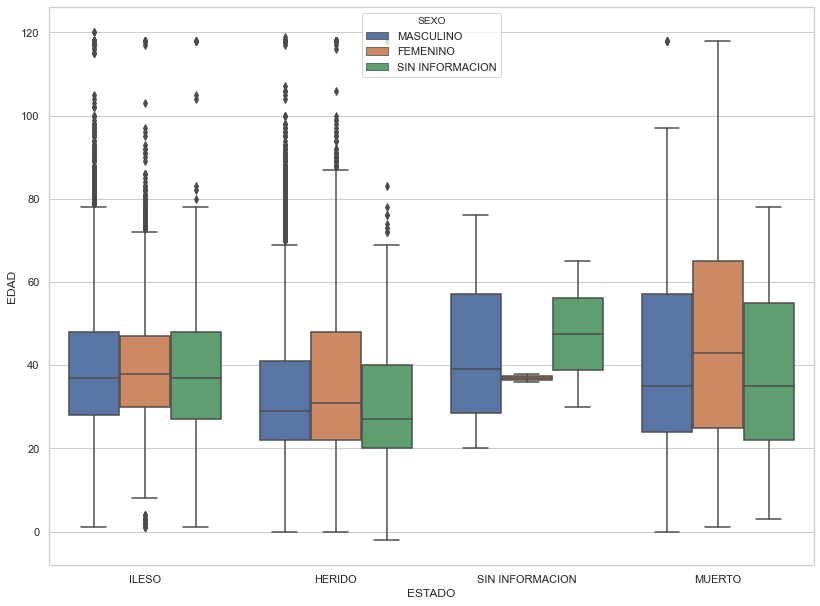

In [148]:
sns.boxplot(x="ESTADO", y="EDAD", hue="SEXO", data=df2);

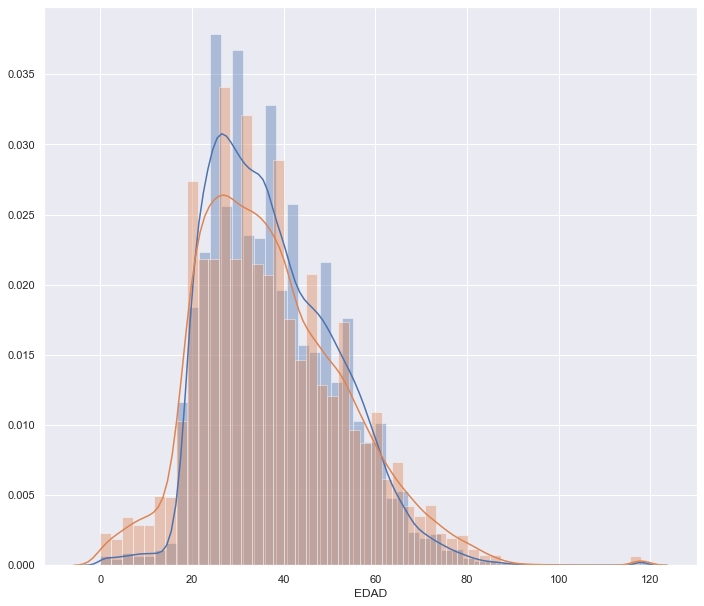

In [31]:
sns.distplot(siniestralidad_actor_vial[siniestralidad_actor_vial['SEXO']=='MASCULINO']['EDAD'].dropna().astype(int))
sns.distplot(siniestralidad_actor_vial[siniestralidad_actor_vial['SEXO']=='FEMENINO']['EDAD'].dropna().astype(int));

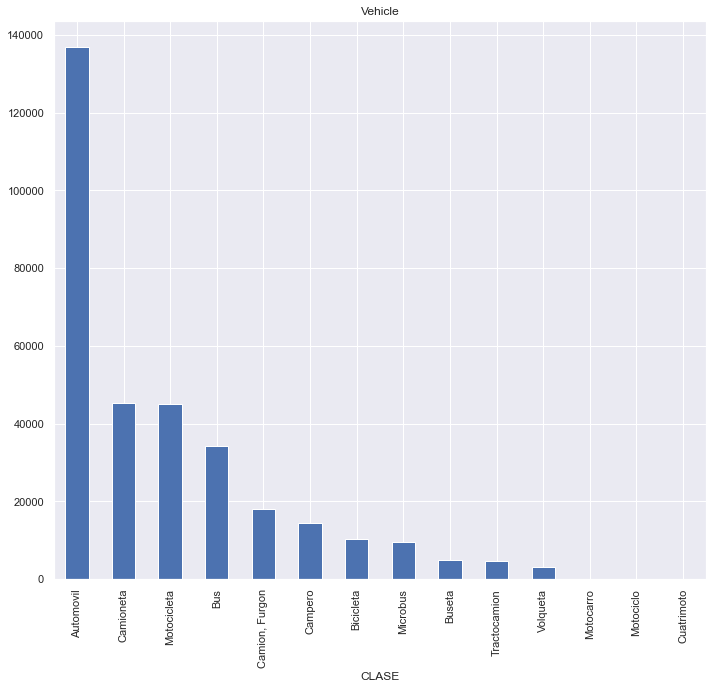

In [47]:
siniestralidad_vehiculos.groupby('CLASE')['CLASE'].count().sort_values(
    ascending=False).plot(kind='bar', title='Vehicle');

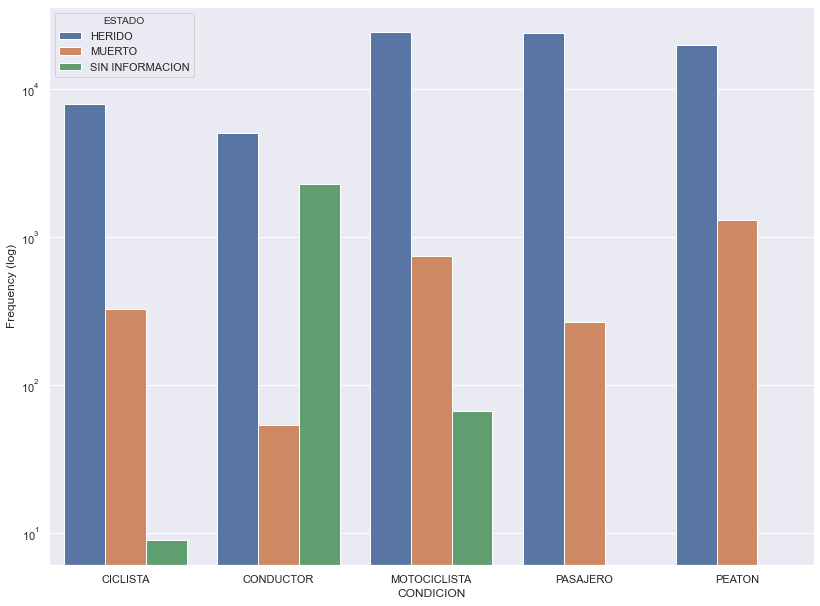

In [75]:
gp = siniestralidad_actor_vial[siniestralidad_actor_vial['ESTADO']!='ILESO'].groupby((
    'CONDICION','ESTADO')).count().reset_index()
gp = pd.DataFrame(gp)
ax = sns.barplot(x='CONDICION', y='SEXO', hue='ESTADO', data=gp)
ax.set(yscale="log",  ylabel = "Frequency (log)");

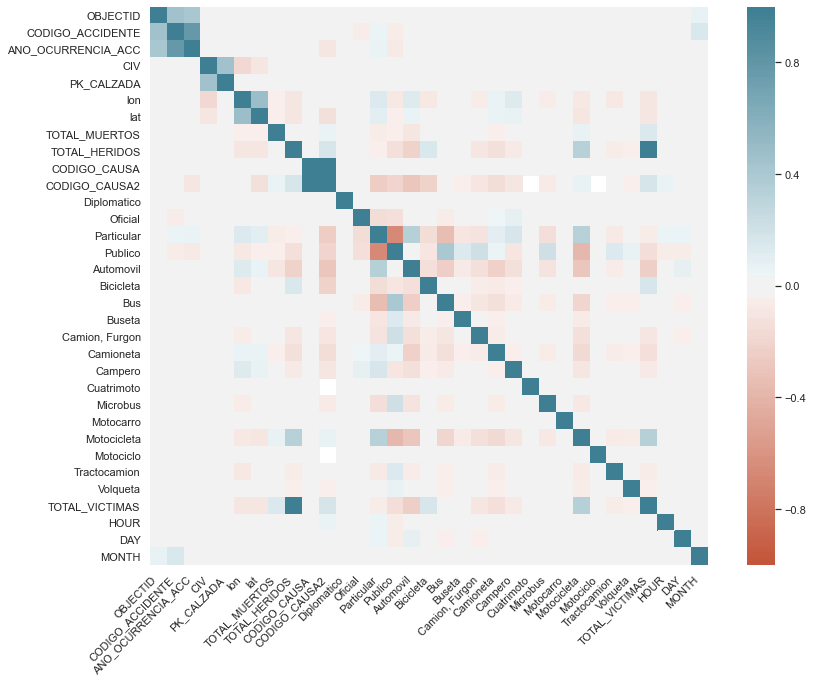

In [149]:

corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [52]:
df[df['Motocicleta']>=0]['TOTAL_VICTIMAS'].sum()

45188

In [76]:
m = folium.Map(width=900, height=1200, location=[4.60971, -74.08175], zoom_start=12)

In [77]:
HeatMap(data=df[['lat', 'lon', 'TOTAL_VICTIMAS']].groupby(
    ['lat', 'lon']).sum(
).reset_index().values.tolist(), radius=8, max_zoom=13).add_to(m);

In [78]:
m

In [81]:
df.to_csv('siniestralidad_sin_actor_vial.csv')

In [82]:
len(df)

189861